In [1]:
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt

import plotly
import plotly.express as px

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import tqdm
#from functools import lru_cache
#import re
import networkx as nx
from networkx.algorithms import approximation


import MDAnalysis as mda

#import scipy
#import sklearn
#import skimage

#import xml.etree.ElementTree as et
#from Bio.PDB import *
#import nglview as nv

from timeit import default_timer as timer


import torch



# http://nglviewer.org/nglview/latest/api.html
# https://biopython.org/wiki/The_Biopython_Structural_Bioinformatics_FAQ
# https://ambermd.org/tutorials/analysis/tutorial_notebooks/nglview_notebook/index.html
# https://amber-md.github.io/pytraj/latest/_api/pytraj.html

In [2]:
#contact_matrix = np.loadtxt('/home/lillo/TesiCNTE/CNTE/dataset/contact_matrix.txt')   #laptop
#contact_matrix = np.loadtxt('/home/lillo/Code/Tesi/dataset/contact_matrix.txt')        #fisso
#contact_matrix_single = contact_matrix.reshape(100,100,12,12)

#gromacs_output = open('/home/lillo/Code/Tesi/dataset/dm4500Compl_mix1_K2_1%4500ns.gro') #fisso
#gromacs_output = open('/home/lillo/TesiCNTE/CNTE/dataset/dm4500Compl_mix1_K2_1%4500ns.gro') #laptop

#path = '/home/lillo/Code/Tesi/dataset/dm4500Compl_mix1_K2_1%4500ns.gro' #fisso
path = '/home/lillo/TesiCNTE/CNTE/dataset/dm4500Compl_mix1_K2_1%4500ns.gro' #laptop

# import 2mxu file (beta sheet)

#path_to_mmCIF = open('/home/lillo/TesiCNTE/pdb/2mxu/2mxu.cif')  ## laptop
#path_to_pdb = '/home/lillo/TesiCNTE/pdb/2mxu/2mxu.pdb'  ## laptop
#pa_to_pdb = '/home/lillo/TesiCNTE/pdb/2mxu/2mxu.pdb'  ## laptop

#path_to_mmCIF = open('/home/lillo/Code/Tesi/pdb/2mxu/2mxu.cif')  ## fisso
#path_to_pdb = '/home/lillo/Code/Tesi/pdb/2mxu/2mxu.pdb'  ## fisso
#pa_to_pdb = '/home/lillo/Code/Tesi/pdb/2mxu/2mxu.pdb'  ## fisso

# aggregate blob

seed_1_path = '/home/lillo/TesiCNTE/from_cluster/aggregate1.gro' # laptop
#seed_1_path = '/home/lillo/Code/Tesi/dataset/aggregate1.gro' # Fisso

# Trajectory with aggregate seed
trj_xtc = '/home/lillo/TesiCNTE/CNTE/trajectory/prd-LDLK12-100mer-out-mol.xtc'  #laptop
trj_gro = '/home/lillo/TesiCNTE/CNTE/trajectory/min-LDLK12-100mer-out-c.gro'  #laptop

#trj_xtc = '/home/lillo/Code/Tesi/dataset/trajectory_6_12_19/prd-LDLK12-100mer-out-mol.xtc'  #fisso
#trj_gro = '/home/lillo/Code/Tesi/dataset/trajectory_6_12_19/min-LDLK12-100mer-out-c.gro'  #fisso


In [ ]:
# READ .gro FILE AND PREPROCESSING

def clean_gro(path):
    
    
        # open file .gro and return a list with one element per line of the .gro file
    def read_gro(path):
        gromacs_output = open(path)

        gro_file = []
        for line in tqdm.tqdm(gromacs_output):
            gro_file.append(line)



        gromacs_output.close()        

        return gro_file



    # return string in a string with numbers
    def return_if_string(string):
        digits = []
        for i in string:
            if not i.isdigit():
                digits.append(i)

        string = ''.join(digits)

        return string


    # return numbers in a string with numbers
    def return_if_digit(string):
        digits = []
        for i in string:
            if i.isdigit():
                digits.append(i)

        string = ''.join(digits)

        return string


    # remove first, second and last lines from gro_file and reorder information
    # FIX OPTION TO GET ENTRY RELATED TO A LABEL (as 'bb' or 'ca')
    def clean_gro_file(gro_file):
        cleaned_gro_file = []
        for aminoacid in tqdm.tqdm(gro_file[2:-1]):
            splitted = aminoacid.split()
            if splitted[1] == 'BB':
                position_in_peptide = return_if_digit(splitted[0])
                residue = return_if_string(splitted[0])
                index = splitted[2]
                x = splitted[3]
                y = splitted[4]
                z = splitted[5]
                cleaned_gro_file.append([index, position_in_peptide, residue, x, y, z])
        return cleaned_gro_file
    
    
    gro_file = read_gro(path)
    cleaned_gro_file = clean_gro_file(gro_file)

    return cleaned_gro_file


# create coordinate dict from cleaned_gro_file
def get_coordinate_dict_from_cleaned_gro(cleaned_gro_file):
    
    peptide_lenght_list = []

    temporary_list = []

    # iterate trough cleaned_gro_file
    for residue in cleaned_gro_file:

        # if temporary list just started, add aminoacid position in chain
        if len(temporary_list) == 0:
            temporary_list.append(int(residue[1]))

        else:
            # if position of actual residue is less than last residue
            if temporary_list[-1] > int(residue[1]):

                # append lenght of last peptide to peptide lenght list
                peptide_lenght_list.append(len(temporary_list))

                # empty temporary list
                temporary_list = []

                # append actual residue position
                temporary_list.append(int(residue[1]))

            # if position of actual residue is higher than last residue, ad current residue position
            else:
                temporary_list.append(int(residue[1]))

    # append last peptide lenght to lenght stack
    peptide_lenght_list.append(len(temporary_list))

    # create empty dict for coordinate
    peptide_coordinate_dict = {}

    # create an entry in dict for every peptide in the file
    for peptide in range(len(peptide_lenght_list)):
        peptide_coordinate_dict[peptide] = {}

        # for every residue in lenght peptide, add coordinate x, y, z
        for residue in range(peptide_lenght_list[peptide]):
            peptide_coordinate_dict[peptide][residue] = [float(coordinate) for coordinate in cleaned_gro_file[(peptide * peptide_lenght_list[peptide])+residue][3:]]

    return peptide_coordinate_dict


# compute euclidean distance
def get_euclidean_distance(point_1, point_2):
    
    euclidean_distance = np.sqrt(np.sum([((point_1[0] - point_2[0])**2), ((point_1[1] - point_2[1])**2), ((point_1[2] - point_2[2])**2)]))

    return euclidean_distance

# compute distance map between two peptides
def compute_distance_map(coordinate_dict, peptide_1, peptide_2):

    distance_map = []
    for amino_1 in coordinate_dict[peptide_1]:
        coordinate_1 = coordinate_dict[peptide_1][amino_1]
        
        distance_map.append([amino_1])
        
        for amino_2 in coordinate_dict[peptide_2]:
            coordinate_2 = coordinate_dict[peptide_2][amino_2]
            
            euclidean_distance = get_euclidean_distance(coordinate_1, coordinate_2)
            distance_map[amino_1].append(euclidean_distance)
        
        del distance_map[amino_1][0]

    distance_map = np.asarray(distance_map)
    
    return distance_map

# compute distance map and return a n_peptide x n_peptide x n_res x n_res array
def compute_distance_maps_from_coordinate_dict(coordinate_dict):
    
    aggregate_distance_map = []

    #for peptide_1 in tqdm.tqdm(coordinate_dict):
    for peptide_1 in coordinate_dict:
        aggregate_distance_map.append([peptide_1])
        
        #for peptide_2 in tqdm.tqdm(coordinate_dict):
        for peptide_2 in coordinate_dict:
            distance_map = compute_distance_map(coordinate_dict, peptide_1, peptide_2)
            
            aggregate_distance_map[peptide_1].append(distance_map)

        del aggregate_distance_map[peptide_1][0]

    aggregate_distance_array = np.asarray(aggregate_distance_map)
    
    return aggregate_distance_array


# COMPUTE CONTACT MAPS
# TO DO: parametrize the threshold distance in a better way (e.g. )
def compute_contact_maps_as_array(distance_maps_array):
    
    # distance between the first and the second aminoacid of the first chain
    intrapeptide_minimum_distance = distance_maps_array[0][0][0][1] 

    contact_map_list = []

    # contact is in a distance up to 150% of the intrapeptide_minimum_distance [TO IMPROVE!!!]
    threshold_distance = (intrapeptide_minimum_distance * 1.5)

    for model_1 in range(distance_maps_array.shape[0]):
        contact_map_list.append([])
        for model_2 in range(distance_maps_array[model_1].shape[0]):

            contact_map_list[model_1].append([])

            if model_1 == model_2:

                contact_map_list[model_1][model_2].extend(np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3])))

            else:

                contact_map = np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3]))

                for chain_1 in range(distance_maps_array[model_1][model_2].shape[0]):

                    for chain_2 in range(distance_maps_array[model_1][model_2][chain_1].shape[0]):

                        distance = distance_maps_array[model_1][model_2][chain_1][chain_2]

                        if distance < threshold_distance:
                            contact_map[chain_1][chain_2] = 1 #True
                        else:
                            pass

                contact_map_list[model_1][model_2].extend(contact_map)
    
    contact_array = np.asarray(contact_map_list)
            
    return contact_array


#### ANALYSIS

def shift_library_maker(contact_map_to_analyze):
    
    ''' riceve numero di righe e di colonne
    restituisce un array shape((((row + col)*2)-2),row,col).
    ogni slice è una diagonale. Lo stack copre le diagonali su tutta la matrice'''
    
    row = contact_map_to_analyze.shape[0]
    col = contact_map_to_analyze.shape[1]
    
    kron_dict = {}
    kron_list_parallel = []
    kron_list_antiparallel = []
    
    for e in range(-row+1, col):
        array = np.eye(row, col, e)
        kron_list_parallel.append(array)
        kron_list_antiparallel.append(np.fliplr(array))
        
    kron_array_parallel = np.asarray(kron_list_parallel)
    kron_array_antiparallel = np.asarray(kron_list_antiparallel)
    
    kron_dict['parallel'] = kron_array_parallel
    kron_dict['antiparallel'] = kron_array_antiparallel
    
    return kron_dict


def normalized_cross_correlation_function(contact_map):
    '''
    Calculate normalized cross correlation function between a contact map and an ideal map.
    
    Arguments : contact map, as output from get_contact_maps function
                shift_matrix_stack, as output from shift_matrix_maker function
                
    Return : a list [ncc_value, index (in the shift_matrix_stack) of the shift matrix
                that is matching the contact map
            
            '''
    shift_matrix_library = shift_library_maker(contact_map)
    
    cross_correlation_values = []
    max_val = []
    sum_contact_map = np.sum(contact_map)
    
    if sum_contact_map < 2:
        pass
    
    else:
        for sense in shift_matrix_library:
            for index, z in enumerate(shift_matrix_library[sense]):

                shift_matrix = shift_matrix_library[sense][index]
                sum_shift_matrix = np.sum(shift_matrix)
                ncc_value = (np.sum((contact_map * shift_matrix))/((np.sqrt(sum_contact_map))*(np.sqrt(sum_shift_matrix))))  # normalized cross correlation function of contact matrix and shift matrix
                cross_correlation_values.append([ncc_value, index, sum_contact_map, sense])

            max_val = max(cross_correlation_values) # get only the best match (highest value of ncc)

    return max_val



def normalized_cross_correlation_for_dataset(contact_array):
    '''Calculate normalized cross correlation function between the full contacts map and and the .
    
    Arguments : contact map, as output from get_contact_maps function
                shift_matrix_stack, as output from shift_matrix_maker function
                
    Return : a list [ncc_value, index (in the shift_matrix_stack) of the shift matrix that is matching the contact map'''
    
    contact_dict = {}
    
    #for row in tqdm.tqdm(range(contact_array.shape[0])):
    for row in range(contact_array.shape[0]):
    
        for col in range((row+1), contact_array.shape[1]):
        #for col in range(contact_array.shape[1]):

            best_match = []
            best_match = normalized_cross_correlation_function(contact_array[row][col])
            
            if len(best_match) == 0:
                pass
            
            else:
                if row in contact_dict:
                    contact_dict[row].append([row, col, best_match])
                
                else:
                    contact_dict[row] = [[row, col, best_match]]
    
    return contact_dict


#denoise dataset
def denoise_full_dataset(contact_maps, normalized_cross_correlation_results):
    
    '''Denoise the contact_maps dataset using the shift_matrix
    
    Arguments : contact_maps, normalized_cross_correlation_result
    
    return : a dict with key:value = row : row, col, denoised_map
    
    '''

    denoised_dict = {}

    for peptide_1 in normalized_cross_correlation_results:
        denoised_dict[peptide_1] = {}
        for index, peptide_2 in enumerate(normalized_cross_correlation_results[peptide_1]):

            row = peptide_2[0]
            col = peptide_2[1]



            contact_map = contact_maps[row][col]
            sense = peptide_2[2][3]
            shift_matrix_index = normalized_cross_correlation_results[peptide_1][index][2][1]

            shift_matrix = shift_library_maker(contact_map)
            shift_matrix = shift_matrix[sense][shift_matrix_index]
            denoised_map = contact_map * shift_matrix

            denoised_dict[row][col] = denoised_map
            
    return denoised_dict


#create a dict that contains the peptide couples contact and the specular peptide couples contact
def reconstruct_full_matrix(denoised_dict):
    full_denoised_dict = {}
    for peptide_1 in tqdm.tqdm(denoised_dict):
        for peptide_2 in denoised_dict[peptide_1]:
            contact_map = denoised_dict[peptide_1][peptide_2]

            if peptide_1 in full_denoised_dict:
                full_denoised_dict[peptide_1][peptide_2] = contact_map

            if peptide_1 not in full_denoised_dict:
                full_denoised_dict[peptide_1] = {peptide_2:contact_map}

            if peptide_2 in full_denoised_dict:
                full_denoised_dict[peptide_2][peptide_1] = contact_map.T

            if peptide_2 not in full_denoised_dict:
                full_denoised_dict[peptide_2] = {peptide_1:contact_map.T}
    
    return full_denoised_dict


# take array, return vector with sum along columns
def get_row_vector(array):
    row_vector = np.sum(array, axis=0)
    return row_vector

# take array, return vector with sum along row
def get_col_vector(array):
    col_vector = np.sum(array, axis=1)
    return col_vector

# graph clustering
def nx_graph_search(denoised_dict):
    
    graph = nx.MultiGraph()
    
    for peptide_1 in denoised_dict:
        for peptide_2 in denoised_dict[peptide_1]:
            array_1 = denoised_dict[peptide_1][peptide_2]
            for peptide_3 in denoised_dict[peptide_2]:
                if peptide_3 != peptide_1:
                    array_2 = denoised_dict[peptide_2][peptide_3]

                    vect_1 = get_row_vector(array_1)
                    vect_2 = get_col_vector(array_2)

                    contacts = np.dot(vect_1, vect_2)
                    
                    if contacts >= 3:

                        graph.add_edge(peptide_1, peptide_2)
                     
                        graph.add_edge(peptide_2, peptide_3)

    return graph

#A novel graph clustering algorithm based on discrete-time quantum random walk
#S.G. Roya, A. Chakrabarti


# working with networkX
# if contacts >= target

# when you add_edge, nodes are created if they are not there
# you can put info in edge (as distance, n of contacts, contact map)
# you HAVE TO (but you can not also) put key to index multiple nodes that are joined with a single node
# 
# add edge from pep1 to pep2 (you HAVE TO (###to explore utility of key) put key to index multiple nodes that are joined with a single node)
# add edge from pep3 to pep3 ( same as before with key)


#FIND SUBGRAPH
def find_subgraph(graph):
    '''
    Find subgraph that have no node in common.
    
    Argument: NetworkX MultiGraph
    
    Return: list of subgraph ordered from one end to the other
    
    '''

    subgraph_list = []
    
    for node in graph:
        
        # don't explore node that are already in subgraph_list
        if node not in set(nod for nod_list in subgraph_list for nod in nod_list):
            
            # tree is the list of nodes joined to node, starting from node
            # using depht first search
            tree = [e for e in nx.algorithms.traversal.depth_first_search.dfs_tree(graph, node)]
            
            # check if the first node of the tree has adjiacency == 1
            # so it checks if it is the first or last node of the subgraph
            if len(graph[tree[0]]) == 1:
                
                if len(subgraph_list) == 0:
                    subgraph_list.append(tree)
                    
                else:
                    # use generator to check if the tree is already in the subgraph
                    if set(tree) not in (set(i) for i in subgraph_list):
                        subgraph_list.append(tree)
                        
    return subgraph_list


########## PLOT PEPTIDE LIST
# plot a list of peptide point cloud in 3d space.
# The box axis have arbitrary scale dependent on the aminoacids distance
# you can select to show the centroid
def plot_peptide_list(coordinate_dict, peptide_list, centroid=False):
    x = []
    y = []
    z = []
    x_median = float
    y_median = float
    z_median = float
    

    for peptide in range(len(peptide_list)):
        x.append([peptide])
        y.append([peptide])
        z.append([peptide])
        for aminoacid in coordinate_dict[peptide_list[peptide]]:

            point = coordinate_dict[peptide_list[peptide]][aminoacid]
            x[peptide].append(point[0])
            y[peptide].append(point[1])
            z[peptide].append(point[2])

        del x[peptide][0]
        del y[peptide][0]
        del z[peptide][0]
        
    if centroid == True:
        
        def assemble_coordinate(axis_coordinate_list):
            median_list = []
            for coordinate_set in axis_coordinate_list:
                median = np.median(coordinate_set)
                median_list.append(median)
            return median_list
        
        x_median = assemble_coordinate(x)
        y_median = assemble_coordinate(y)
        z_median = assemble_coordinate(z)
        

    #%matplotlib notebook

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    for pep in range(len(x)):
       
        ax.scatter3D(x[pep],y[pep],z[pep])
        
        if centroid == True:
            
            ax.scatter3D(x_median[pep], y_median[pep], z_median[pep], c='red')
            
        
    #return  plt.show(), [x,y,z], [x_median, y_median, z_median]
    return  plt.show()



# get average distance map from distance maps set
def get_mean_distance_map(distance_maps):
    '''
    Calculate mean distance map from distance maps set
    
    Argument: distance maps set
    
    return: np.array with average intrapeptide distance
    
    '''
    
    # create array of zeros of shape number_of_residues * number_of_residues
    # depending on peptide residue number ### TO FIX FOR MULTIMONOMERIC ASSEMBLY
    base = np.zeros((distance_maps[0][0].shape[0], distance_maps[0][0].shape[1]))
    
    # initialize counter
    counter = 0
    
    # iterate throught peptides in the aggregate
    for peptide_1 in range(distance_maps.shape[0]):
        for peptide_2 in range(distance_maps.shape[1]):
             
            # if peptide index are the same (intrapeptide distance map)
            if peptide_1 == peptide_2:
                
                # intrapeptide distance map
                actual_distance_map = distance_maps[peptide_1][peptide_2]
                
                # sum base and current distance map
                base = base + actual_distance_map
                
                #update counter
                counter += 1

    #for element in base (every element is the sum of distance_map(i,j) for every distance map)
    for row in range(len(base)):
        for col in range(len(base)):
            
            # find the mean for every element of the cumulative distance map
            base[row][col] = (base[row][col])/counter
            
    return base


def decompose_distance_map(distance_map):
    '''Use Singular value decomposition to get
    
    distance_map.shape[1] dimensional coordinate
    (same n of dimension as the peptide n of residue)
    
    As described in:
    Mathematical Modeling of Protein Structure Using Distance Geometry
    Jeong-Mi Yoon, Yash Gad, Zhijun Wu
    
    Argument: distance map (numpy.array 2D)
    return: X : actual decomposition
            
    
    '''
    
    # initialize a zeros matrix of same shape as the input map
    D = np.zeros(distance_map.shape)
    
    #iterate trought row
    for i in range(distance_map.shape[0]):
        
        # iterate trought cols
        for j in range(distance_map.shape[1]):
            
            # distance between point point i and point j 
            dij = distance_map[i][j]
            
            # distance between point 0 and point j
            d0j = distance_map[0][j]
            
            #distance between point i and point 0
            di0 = distance_map[i][0]

            #fill the zeros matrix with the value obtained with this formula
            D[i][j] = (d0j**2 + di0**2 - dij**2)/2
            
    # check rank of matrix (should be of rank 3, but it is of rank distance_map.shape[1])
    rank = np.linalg.matrix_rank(D)
    
    # Singular value decomposition on the D matrix
    #svd = np.linalg.svd(D)
    
    svd = np.linalg.svd(D, full_matrices=False)
    
    # Calculate distance_map.shape[1] dimensional coordinate, but you need 3
    # the non necessary dimension can give data to better reconstruct the peptide structure
    X = svd[0]*np.sqrt(svd[1])

    
    #return X, svd, D, rank
    return X

def get_coordinate_from_decomposition(decomposition):
    '''Take decomposition result and convert it into a coordinate vectors dict
    
    Argument: decomposition results
    
    return: dict with reconstructed 3d coordinate vector
    
    '''
    
    # take only the first three value to compose a 3D coordinate vector
    coordinate = [e[:3] for e in decomposition]
    
    # initialize empty dict
    reconstructed_coordinate_dict = {}
    
    # fill the dict with the ccordinate vectors
    for index,coordinate_vector in enumerate(coordinate):
        reconstructed_coordinate_dict[index] = coordinate_vector
    
    return reconstructed_coordinate_dict


# 
def get_coordinate_from_distance_map(distance_map):
    ''' compute 3d coordinate from distance map
    
    Argument: distance_map (numpy.array)
    
    return: dict with 3d coordinate for every alpha-carbon of a peptide
    
    '''
    # perform singular value decomposition on distance_map (preprocessed)
    decomposed_mean_distance_map = decompose_distance_map(distance_map)
    
    
    # get 3D coordinate
    reconstructed_coordinate_dict = get_coordinate_from_decomposition(decomposed_mean_distance_map)
    
    return reconstructed_coordinate_dict

    
    
def plot_single_peptide(peptide_coordinate_dict, centroid=False):
    x = []
    y = []
    z = []
    
    for residue in peptide_coordinate_dict:
        point = peptide_coordinate_dict[residue]
        x.append(point[0])
        y.append(point[1])
        z.append(point[2])


    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(x,y,z, c='b')
    
    if centroid == True:
            median_centroid = [np.median(x), np.median(y), np.median(z)]
            ax.scatter3D(median_centroid[0], median_centroid[1], median_centroid[2], c='r')
            
    return plt.show()


In [ ]:
# open and clean .gro file
# return list with an entry for every residue plus info
start = timer()
cleaned_gro_seed_1 = clean_gro(seed_1_path)
end = timer()
print(end - start)

# return a dict with residue coordinate
start = timer()
coordinate_dict_seed_1 = get_coordinate_dict_from_cleaned_gro(cleaned_gro_seed_1)
end = timer()
print(end - start)

# compute distance maps and return a n_peptide x n_peptide x n_res x n_res array ## from .gro coordinate dict
start = timer()
distance_maps_seed_1 = compute_distance_maps_from_coordinate_dict(coordinate_dict_seed_1)
end = timer()
print(end-start)

# compute contact maps from distance maps
start = timer()
contact_maps_seed_1 = compute_contact_maps_as_array(distance_maps_seed_1)
end = timer()
print(end-start)

# compute cross correlation and get values
start = timer()
normalized_cross_correlation_results_seed_1 = normalized_cross_correlation_for_dataset(contact_maps_seed_1)
end = timer()
print(end-start)

# denoise dataset
start = timer()
denoised_dict_seed_1 = denoise_full_dataset(contact_maps_seed_1, normalized_cross_correlation_results_seed_1)
end = timer()
print(end-start)

# recreate full contact map dataset mirrroring the upper triangle
# return dict
start = timer()
full_denoised_dict_seed_1 = reconstruct_full_matrix(denoised_dict_seed_1)
end = timer()
print(end-start)

#create graph
start = timer()
graph_seed_1 = nx_graph_search(full_denoised_dict_seed_1)
end = timer()
print(end-start)

#search subgraph
start = timer()
subgrap_list_seed_1 = find_subgraph(graph_seed_1)
end = timer()
print(end-start)

#find mean distance map
start = timer()
mean_distance_map_seed_1 = get_mean_distance_map(distance_maps_seed_1)
end = timer()
print(end-start)

# decompose mean distance matrix
start = timer()
decomposed_mean_distance_map = decompose_distance_map(mean_distance_map_seed_1)
end = timer()
print(end-start)
      
# get coordinate from distance map      
start = timer()
reconstructed_coordinate_dict = get_coordinate_from_decomposition(decomposed_mean_distance_map)
end = timer()
print(end-start)


In [ ]:
# RUN THIS FOR 3D VIEW OF PLOT

%matplotlib notebook

In [ ]:
# RUN THIS TO CLOSE ALL PLOT (run multiple time this cell if it does not work)
plt.close()

In [ ]:
# plot the reconstructed average peptide 
plot_single_peptide(reconstructed_coordinate_dict)

In [ ]:
# plot full coordinate from dict
plot_peptide_list(coordinate_dict_seed_1, [e for e in coordinate_dict_seed_1])

In [ ]:
### TRAJECTORY

# using mdanalysis module


#create Universe from a .gro with coordinates and an .xtc with the trajectory data
u = mda.Universe(trj_gro,trj_xtc)

In [ ]:
# create a dict from a Universe in which each entry is a timestep of the MD simulation
def create_trajectory_dict(u):
    bb = u.select_atoms('name BB')
    trajectory_dict = {}
    for index, time_steps in enumerate(u.trajectory):
        trajectory_dict[index] = bb.positions
    return trajectory_dict

# make trajectory dict
trajectory_dict = create_trajectory_dict(u)

In [ ]:
#if you change the number in the first parentesis, you change timestep
#second parentesis are the bb grains
pep = trajectory_dict[0][:1200] # this are all the coordinate of bb grains of timestep 0, as an array

#cast coordinate from array to dict
zero_c = get_coordinate_from_decomposition(pep)

#plot dict as a single object
plot_single_peptide(zero_c)

In [ ]:
# To see the trajectory you need to install ngl-view
# https://github.com/arose/nglview
#
# pay attention to this:
#   pip install nglview
#
# in a terminal, in the env where ngl-view is installed, send this:
# jupyter-nbextension enable nglview --py --sys-prefix
#


view = nv.show_mdanalysis(u)

In [ ]:
view

In [30]:
class morphoscanner():
    
    
    
    class math_utility():

        # take array, return vector with sum along columns
        def get_row_vector(array):
            row_vector = np.sum(array, axis=0)
            return row_vector

        # take array, return vector with sum along row
        def get_col_vector(array):
            col_vector = np.sum(array, axis=1)
            return col_vector
        
        
    class utility():
        
        def get_coordinate_dict_from_array(array):
            '''Take decomposition result and convert it into a coordinate vectors dict

            Argument: decomposition results

            return: dict with reconstructed 3d coordinate vector

            '''

            # make list with n == array.shape[0]
            coordinate = [e for e in array]

            # initialize empty dict
            reconstructed_coordinate_dict = {}

            # fill the dict with the ccordinate vectors
            for index,coordinate_vector in enumerate(coordinate):
                reconstructed_coordinate_dict[index] = coordinate_vector

            return reconstructed_coordinate_dict

    
    
    
    class read():
        
        # READ .gro FILE AND PREPROCESSING

        def clean_gro(path):


                # open file .gro and return a list with one element per line of the .gro file
            def read_gro(path):
                gromacs_output = open(path)

                gro_file = []
                for line in tqdm.tqdm(gromacs_output):
                    gro_file.append(line)



                gromacs_output.close()        

                return gro_file



            # return string in a string with numbers
            def return_if_string(string):
                digits = []
                for i in string:
                    if not i.isdigit():
                        digits.append(i)

                string = ''.join(digits)

                return string


            # return numbers in a string with numbers
            def return_if_digit(string):
                digits = []
                for i in string:
                    if i.isdigit():
                        digits.append(i)

                string = ''.join(digits)

                return string


            # remove first, second and last lines from gro_file and reorder information
            # FIX OPTION TO GET ENTRY RELATED TO A LABEL (as 'bb' or 'ca')
            def clean_gro_file(gro_file):
                cleaned_gro_file = []
                for aminoacid in tqdm.tqdm(gro_file[2:-1]):
                    splitted = aminoacid.split()
                    if splitted[1] == 'BB':
                        position_in_peptide = return_if_digit(splitted[0])
                        residue = return_if_string(splitted[0])
                        index = splitted[2]
                        x = splitted[3]
                        y = splitted[4]
                        z = splitted[5]
                        cleaned_gro_file.append([index, position_in_peptide, residue, x, y, z])
                return cleaned_gro_file


            gro_file = read_gro(path)
            cleaned_gro_file = clean_gro_file(gro_file)

            return cleaned_gro_file
        
        # create coordinate dict from cleaned_gro_file
        def get_coordinate_dict_from_cleaned_gro(cleaned_gro_file):

            peptide_lenght_list = []

            temporary_list = []

            # iterate trough cleaned_gro_file
            for residue in cleaned_gro_file:

                # if temporary list just started, add aminoacid position in chain
                if len(temporary_list) == 0:
                    temporary_list.append(int(residue[1]))

                else:
                    # if position of actual residue is less than last residue
                    if temporary_list[-1] > int(residue[1]):

                        # append lenght of last peptide to peptide lenght list
                        peptide_lenght_list.append(len(temporary_list))

                        # empty temporary list
                        temporary_list = []

                        # append actual residue position
                        temporary_list.append(int(residue[1]))

                    # if position of actual residue is higher than last residue, ad current residue position
                    else:
                        temporary_list.append(int(residue[1]))

            # append last peptide lenght to lenght stack
            peptide_lenght_list.append(len(temporary_list))

            # create empty dict for coordinate
            peptide_coordinate_dict = {}

            # create an entry in dict for every peptide in the file
            for peptide in range(len(peptide_lenght_list)):
                peptide_coordinate_dict[peptide] = {}

                # for every residue in lenght peptide, add coordinate x, y, z
                for residue in range(peptide_lenght_list[peptide]):
                    peptide_coordinate_dict[peptide][residue] = [float(coordinate) for coordinate in cleaned_gro_file[(peptide * peptide_lenght_list[peptide])+residue][3:]]

            return peptide_coordinate_dict
        
        
        def get_coordinate_dict_from_cleaned_gro_for_fixed_lenght_peptides(cleaned_gro_file, peptide_lenght):
            '''Works only with system made of peptide of equal peptide length
                (the peptide in the trajectory have all the same number of aminoacids).

            Usefull to disassemble premade aggregate in a system of omogenous peptide lenght'''

            peptide_coordinate_dict = {}

            for peptide in range(len(cleaned_gro_file)//peptide_lenght):

                peptide_coordinate_dict[peptide] = {}

                peptide_data = cleaned_gro_file[(peptide*peptide_lenght):((peptide*peptide_lenght)+peptide_lenght)]

                for index, amino in enumerate(peptide_data):

                    peptide_coordinate_dict[peptide][index] = [float(amino[3]), float(amino[4]), float(amino[5])] ## can you generalize this 3? Maybe with re or isdigit function??

            return peptide_coordinate_dict
        

    
    
    
    
    
    
    
    
    class distance():
        
        # compute euclidean distance
        def get_euclidean_distance(point_1, point_2):

            euclidean_distance = np.sqrt(np.sum([((point_1[0] - point_2[0])**2), ((point_1[1] - point_2[1])**2), ((point_1[2] - point_2[2])**2)]))

            return euclidean_distance

        # compute distance map between two peptides
        def compute_distance_map(coordinate_dict, peptide_1, peptide_2):

            distance_map = []
            for amino_1 in coordinate_dict[peptide_1]:
                coordinate_1 = coordinate_dict[peptide_1][amino_1]

                distance_map.append([amino_1])

                for amino_2 in coordinate_dict[peptide_2]:
                    coordinate_2 = coordinate_dict[peptide_2][amino_2]

                    euclidean_distance = morphoscanner.distance.get_euclidean_distance(coordinate_1, coordinate_2)
                    distance_map[amino_1].append(euclidean_distance)

                del distance_map[amino_1][0]

            distance_map = np.asarray(distance_map)

            return distance_map

        # compute distance map and return a n_peptide x n_peptide x n_res x n_res array
        def compute_distance_maps_from_coordinate_dict(coordinate_dict):

            aggregate_distance_map = []

            for peptide_1 in tqdm.tqdm(coordinate_dict):
            #for peptide_1 in coordinate_dict:
                aggregate_distance_map.append([peptide_1])

                #for peptide_2 in tqdm.tqdm(coordinate_dict):
                for peptide_2 in coordinate_dict:
                    distance_map = morphoscanner.distance.compute_distance_map(coordinate_dict, peptide_1, peptide_2)

                    aggregate_distance_map[peptide_1].append(distance_map)

                del aggregate_distance_map[peptide_1][0]

            aggregate_distance_array = np.asarray(aggregate_distance_map)

            return aggregate_distance_array


        # COMPUTE CONTACT MAPS
        # TO DO: parametrize the threshold distance in a better way (e.g. )
        def compute_contact_maps_as_array(distance_maps_array):

            # distance between the first and the second aminoacid of the first chain
            intrapeptide_minimum_distance = distance_maps_array[0][0][0][1] 

            contact_map_list = []

            # contact is in a distance up to 150% of the intrapeptide_minimum_distance [TO IMPROVE!!!]
            threshold_distance = (intrapeptide_minimum_distance * 1.5)

            for model_1 in range(distance_maps_array.shape[0]):
                contact_map_list.append([])
                for model_2 in range(distance_maps_array[model_1].shape[0]):

                    contact_map_list[model_1].append([])

                    if model_1 == model_2:

                        contact_map_list[model_1][model_2].extend(np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3])))

                    else:

                        contact_map = np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3]))

                        for chain_1 in range(distance_maps_array[model_1][model_2].shape[0]):

                            for chain_2 in range(distance_maps_array[model_1][model_2][chain_1].shape[0]):

                                distance = distance_maps_array[model_1][model_2][chain_1][chain_2]

                                if distance < threshold_distance:
                                    contact_map[chain_1][chain_2] = 1 #True
                                else:
                                    pass

                        contact_map_list[model_1][model_2].extend(contact_map)

            contact_array = np.asarray(contact_map_list)

            return contact_array
        
        
        
        # get average distance map from distance maps set
        def get_mean_distance_map(distance_maps):
            '''
            Calculate mean distance map from distance maps set

            Argument: distance maps set

            return: np.array with average intrapeptide distance

            '''

            # create array of zeros of shape number_of_residues * number_of_residues
            # depending on peptide residue number ### TO FIX FOR MULTIMONOMERIC ASSEMBLY
            base = np.zeros((distance_maps[0][0].shape[0], distance_maps[0][0].shape[1]))

            # initialize counter
            counter = 0

            # iterate throught peptides in the aggregate
            for peptide_1 in range(distance_maps.shape[0]):
                for peptide_2 in range(distance_maps.shape[1]):

                    # if peptide index are the same (intrapeptide distance map)
                    if peptide_1 == peptide_2:

                        # intrapeptide distance map
                        actual_distance_map = distance_maps[peptide_1][peptide_2]

                        # sum base and current distance map
                        base = base + actual_distance_map

                        #update counter
                        counter += 1

            #for element in base (every element is the sum of distance_map(i,j) for every distance map)
            for row in range(len(base)):
                for col in range(len(base)):

                    # find the mean for every element of the cumulative distance map
                    base[row][col] = (base[row][col])/counter

            return base

        # Singolar Value Decomposition of distance_map
        def decompose_distance_map(distance_map):
            '''Use Singular value decomposition to get

            distance_map.shape[1] dimensional coordinate
            (same n of dimension as the peptide n of residue)

            As described in:
            Mathematical Modeling of Protein Structure Using Distance Geometry
            Jeong-Mi Yoon, Yash Gad, Zhijun Wu

            Argument: distance map (numpy.array 2D)
            return: X : actual decomposition


            '''

            # initialize a zeros matrix of same shape as the input map
            D = np.zeros(distance_map.shape)

            #iterate trought row
            for i in range(distance_map.shape[0]):

                # iterate trought cols
                for j in range(distance_map.shape[1]):

                    # distance between point point i and point j 
                    dij = distance_map[i][j]

                    # distance between point 0 and point j
                    d0j = distance_map[0][j]

                    #distance between point i and point 0
                    di0 = distance_map[i][0]

                    #fill the zeros matrix with the value obtained with this formula
                    D[i][j] = (d0j**2 + di0**2 - dij**2)/2

            # check rank of matrix (should be of rank 3, but it is of rank distance_map.shape[1])
            #rank = np.linalg.matrix_rank(D)

            # Singular value decomposition on the D matrix
            #svd = np.linalg.svd(D)

            svd = np.linalg.svd(D, full_matrices=False)

            # Calculate distance_map.shape[1] dimensional coordinate, but you need 3
            # the non necessary dimension can give data to better reconstruct the peptide structure
            X = svd[0]*np.sqrt(svd[1])


            #return X, svd, D, rank
            return X

        def get_coordinate_from_decomposition(decomposition):
            '''Take decomposition result and convert it into a coordinate vectors dict

            Argument: decomposition results

            return: dict with reconstructed 3d coordinate vector

            '''

            # take only the first three value to compose a 3D coordinate vector
            coordinate = [e[:3] for e in decomposition]

            # initialize empty dict
            reconstructed_coordinate_dict = {}

            # fill the dict with the ccordinate vectors
            for index,coordinate_vector in enumerate(coordinate):
                reconstructed_coordinate_dict[index] = coordinate_vector

            return reconstructed_coordinate_dict


        # reconstruct 3d coordinate from a distance map
        def get_coordinate_from_distance_map(distance_map):
            ''' compute 3d coordinate from distance map

            Argument: distance_map (numpy.array)

            return: dict with 3d coordinate for every alpha-carbon of a peptide

            '''
            # perform singular value decomposition on distance_map (preprocessed)
            decomposed_mean_distance_map = decompose_distance_map(distance_map)


            # get 3D coordinate
            reconstructed_coordinate_dict = get_coordinate_from_decomposition(decomposed_mean_distance_map)

            return reconstructed_coordinate_dict
        
    
    
    
    
    
    
    
    class distance_tensor():
        
        # instantiate 3d tensor with shape n_peptides * n_residues * n_dimension
        def get_coordinate_tensor(coordinate_dict):
    
            #variables wit dict dimension
            dim0 = len(coordinate_dict)
            dim1 = len(coordinate_dict[0])
            dim2 = len(coordinate_dict[0][0])

            #initialize a 0s tensor
            zero = torch.zeros([dim0,dim1,dim2], dtype=torch.float32, device='cuda')


            for peptide in coordinate_dict:

                for aminoacid in coordinate_dict[peptide]:

                    # create toorch tensor on cuda device with cordinate [x,y,z...]
                    zero[peptide][aminoacid] = torch.cuda.FloatTensor(coordinate_dict[peptide][aminoacid])

            return zero
        
        

        
        #compute euclidean norm, fast
        def compute_euclidean_norm_torch(coordinate_tensor):
            '''Use matrix to compute euclidean distance dataset wise
                and return a set of distance matrix for everi couple of peptides

            ****Runs in parallel on CUDA devices.

            Argument: tensor of shape n_peptide * n_residue * number of dimension (3 for 3d)

            return: tensor of shape n_peptide * n_peptide * n_residue * n_peptide

            '''

            #create tensor of 0s with shape n_pep x n_pep * n_res + n_res
            zero = torch.zeros((coordinate_tensor.shape[0], coordinate_tensor.shape[0], coordinate_tensor.shape[1], coordinate_tensor.shape[1]), dtype=torch.float32, device='cuda')

            #cicle on peptide
            for index1, peptide1 in tqdm.tqdm(enumerate(coordinate_tens)):

                #cicle on peptide (upper triangle + diagonal)
                for index2 in range(index1, coordinate_tens.shape[0]):
                #for index2 in range(coordinate_tens.shape[0]):

                    #coordinate vector
                    peptide2 = coordinate_tens[index2]

                    x_norm = torch.pow(peptide1, 2).sum(1).view(-1,1)
                    y_t = torch.transpose(peptide2, 0, 1)
                    y_norm = torch.pow(peptide2, 2).sum(1).view(1,-1)

                    dist = torch.sqrt(x_norm + y_norm - 2.0 * torch.mm(peptide1, y_t))

                    #dist = x_norm + y_norm - 2.0 * torch.mm(peptide1, y_t)
                    #fine = torch.clamp(dist, 0.0, np.inf) #should be there, but is not working somehow

                    # add distance map in the right position of the 0s tensor
                    zero[index1][index2] = dist

                    # if mesuring between different peptides
                    if index1 != index2:
                        # put transpose of distance map in lower triangle
                        zero[index2][index1] = dist.transpose(1,0)

            #convert nan to 0  (using this instead of torch.clamp())       
            zero[torch.isnan(zero)] = 0
            
            # move to system memory and cast to numpy array
            zero = zero.cpu().numpy()
    
            return zero # .cpu() to move on system memory
        
        #https://discuss.pytorch.org/t/efficient-distance-matrix-computation/9065
        #https://www.dropbox.com/h?preview=Parallel+Euclidean+distance+matrix+computation+on+big+datasets.pdf      
        
        
        

        
        
        
        
        
        
        
        
        
    class cross_correlation():
        
        #### ANALYSIS

        def shift_library_maker(contact_map_to_analyze):

            ''' riceve numero di righe e di colonne
            restituisce un array shape((((row + col)*2)-2),row,col).
            ogni slice è una diagonale. Lo stack copre le diagonali su tutta la matrice'''

            row = contact_map_to_analyze.shape[0]
            col = contact_map_to_analyze.shape[1]

            kron_dict = {}
            kron_list_parallel = []
            kron_list_antiparallel = []

            for e in range(-row+1, col):
                array = np.eye(row, col, e)
                kron_list_parallel.append(array)
                kron_list_antiparallel.append(np.fliplr(array))

            kron_array_parallel = np.asarray(kron_list_parallel)
            kron_array_antiparallel = np.asarray(kron_list_antiparallel)

            kron_dict['parallel'] = kron_array_parallel
            kron_dict['antiparallel'] = kron_array_antiparallel

            return kron_dict


        def normalized_cross_correlation_function(contact_map):
            '''
            Calculate normalized cross correlation function between a contact map and an ideal map.

            Arguments : contact map, as output from get_contact_maps function
                        shift_matrix_stack, as output from shift_matrix_maker function

            Return : a list [ncc_value, index (in the shift_matrix_stack) of the shift matrix
                        that is matching the contact map

                    '''
            shift_matrix_library = morphoscanner.cross_correlation.shift_library_maker(contact_map)

            cross_correlation_values = []
            max_val = []
            sum_contact_map = np.sum(contact_map)

            if sum_contact_map < 2:
                pass

            else:
                for sense in shift_matrix_library:
                    for index, z in enumerate(shift_matrix_library[sense]):

                        shift_matrix = shift_matrix_library[sense][index]
                        sum_shift_matrix = np.sum(shift_matrix)
                        ncc_value = (np.sum((contact_map * shift_matrix))/((np.sqrt(sum_contact_map))*(np.sqrt(sum_shift_matrix))))  # normalized cross correlation function of contact matrix and shift matrix
                        cross_correlation_values.append([ncc_value, index, sum_contact_map, sense])

                    max_val = max(cross_correlation_values) # get only the best match (highest value of ncc)

            return max_val



        def normalized_cross_correlation_for_dataset(contact_array):
            '''Calculate normalized cross correlation function between the full contacts map and and the .

            Arguments : contact map, as output from get_contact_maps function
                        shift_matrix_stack, as output from shift_matrix_maker function

            Return : a list [ncc_value, index (in the shift_matrix_stack) of the shift matrix that is matching the contact map'''

            contact_dict = {}

            #for row in tqdm.tqdm(range(contact_array.shape[0])):
            for row in range(contact_array.shape[0]):

                for col in range((row+1), contact_array.shape[1]):
                #for col in range(contact_array.shape[1]):

                    best_match = []
                    best_match = morphoscanner.cross_correlation.normalized_cross_correlation_function(contact_array[row][col])

                    if len(best_match) == 0:
                        pass

                    else:
                        if row in contact_dict:
                            contact_dict[row].append([row, col, best_match])

                        else:
                            contact_dict[row] = [[row, col, best_match]]

            return contact_dict
        
        
    
    
    
    
    

    
    
    class denoise():
        
        
        #denoise dataset
        def denoise_contact_maps(contact_maps):
            
            '''Denoise the contact_maps dataset using the shift_matrix
            
            Arguments : contact_maps, normalized_cross_correlation_result
            
            return : a dict with key:value = row : row, col, denoised_map
            
            '''
        
            normalized_cross_correlation_results = morphoscanner.cross_correlation.normalized_cross_correlation_for_dataset(contact_maps)
        
        
            denoised_dict = {}
        
            for peptide_1 in normalized_cross_correlation_results:
                denoised_dict[peptide_1] = {}
                for index, peptide_2 in enumerate(normalized_cross_correlation_results[peptide_1]):
        
                    row = peptide_2[0]
                    col = peptide_2[1]
        
        
        
                    contact_map = contact_maps[row][col]
                    sense = peptide_2[2][3]
                    shift_matrix_index = normalized_cross_correlation_results[peptide_1][index][2][1]
        
                    shift_matrix = morphoscanner.cross_correlation.shift_library_maker(contact_map)
                    shift_matrix = shift_matrix[sense][shift_matrix_index]
                    denoised_map = contact_map * shift_matrix
        
                    denoised_dict[row][col] = denoised_map
                    
                    
            full_denoised_dict = {}
            for peptide_1 in tqdm.tqdm(denoised_dict):
                for peptide_2 in denoised_dict[peptide_1]:
                    contact_map = denoised_dict[peptide_1][peptide_2]
        
                    if peptide_1 in full_denoised_dict:
                        full_denoised_dict[peptide_1][peptide_2] = contact_map
        
                    if peptide_1 not in full_denoised_dict:
                        full_denoised_dict[peptide_1] = {peptide_2:contact_map}
        
                    if peptide_2 in full_denoised_dict:
                        full_denoised_dict[peptide_2][peptide_1] = contact_map.T
        
                    if peptide_2 not in full_denoised_dict:
                        full_denoised_dict[peptide_2] = {peptide_1:contact_map.T}
            
            return full_denoised_dict
         
        

        
    
    
    
    
    
    
    
    
    
    class graph():
        
        # graph clustering
        def nx_graph_search(denoised_dict):

            graph = nx.MultiGraph()

            for peptide_1 in denoised_dict:
                for peptide_2 in denoised_dict[peptide_1]:
                    array_1 = denoised_dict[peptide_1][peptide_2]
                    for peptide_3 in denoised_dict[peptide_2]:
                        if peptide_3 != peptide_1:
                            array_2 = denoised_dict[peptide_2][peptide_3]

                            vect_1 = morphoscanner.math_utility.get_row_vector(array_1)
                            vect_2 = morphoscanner.math_utility.get_col_vector(array_2)

                            contacts = np.dot(vect_1, vect_2)

                            if contacts >= 3:

                                graph.add_edge(peptide_1, peptide_2)

                                graph.add_edge(peptide_2, peptide_3)

            return graph

        #A novel graph clustering algorithm based on discrete-time quantum random walk
        #S.G. Roya, A. Chakrabarti


        # working with networkX
        # if contacts >= target

        # when you add_edge, nodes are created if they are not there
        # you can put info in edge (as distance, n of contacts, contact map)
        # you  can   put key to index multiple nodes that are joined with a single node
        # 
        # add edge from pep1 to pep2 (you HAVE TO (###to explore utility of key) put key to index multiple nodes that are joined with a single node)
        # add edge from pep3 to pep3 ( same as before with key)


        #FIND SUBGRAPH
        def find_subgraph(graph):
            '''
            Find subgraph that have no node in common.

            Argument: NetworkX MultiGraph

            Return: list of subgraph ordered from one end to the other

            '''

            subgraph_list = []

            for node in graph:

                # don't explore node that are already in subgraph_list
                if node not in set(nod for nod_list in subgraph_list for nod in nod_list):

                    # tree is the list of nodes joined to node, starting from node
                    # using depht first search
                    tree = [e for e in nx.algorithms.traversal.depth_first_search.dfs_tree(graph, node)]

                    # check if the first node of the tree has adjiacency == 1
                    # so it checks if it is the first or last node of the subgraph
                    if len(graph[tree[0]]) == 1:

                        if len(subgraph_list) == 0:
                            subgraph_list.append(tree)

                        else:
                            # use generator to check if the tree is already in the subgraph
                            if set(tree) not in (set(i) for i in subgraph_list):
                                subgraph_list.append(tree)

            return subgraph_list
    
    
    
    
    
        
        
        
              
        
        
        
        
        
    class plot():
        
        
        ########## PLOT PEPTIDE LIST
        # plot a list of peptide point cloud in 3d space.
        # The box axis have arbitrary scale dependent on the aminoacids distance
        # you can select to show the centroid
        def plot_peptide_list(coordinate_dict, peptide_list, centroid=False):
            x = []
            y = []
            z = []
            x_median = float
            y_median = float
            z_median = float


            for peptide in range(len(peptide_list)):
                x.append([peptide])
                y.append([peptide])
                z.append([peptide])
                for aminoacid in coordinate_dict[peptide_list[peptide]]:

                    point = coordinate_dict[peptide_list[peptide]][aminoacid]
                    x[peptide].append(point[0])
                    y[peptide].append(point[1])
                    z[peptide].append(point[2])

                del x[peptide][0]
                del y[peptide][0]
                del z[peptide][0]

            if centroid == True:

                def assemble_coordinate(axis_coordinate_list):
                    median_list = []
                    for coordinate_set in axis_coordinate_list:
                        median = np.median(coordinate_set)
                        median_list.append(median)
                    return median_list

                x_median = assemble_coordinate(x)
                y_median = assemble_coordinate(y)
                z_median = assemble_coordinate(z)


            #%matplotlib notebook

            fig = plt.figure()
            
            ax = plt.axes(projection='3d')
            

            for pep in range(len(x)):

                ax.scatter3D(x[pep],y[pep],z[pep])

                if centroid == True:

                    ax.scatter3D(x_median[pep], y_median[pep], z_median[pep], c='red')


            #return  plt.show(), [x,y,z], [x_median, y_median, z_median]         
            return plt.show()
        
        
        
        #plot from tensor
        def plot_peptide_from_tensor(coordinate_dict, peptide_list, centroid=False):

            x = []
            y = []
            z = []
            x_median = float
            y_median = float
            z_median = float


            for peptide in range(len(peptide_list)):
                x.append([peptide])
                y.append([peptide])
                z.append([peptide])
                for index, aminoacid in enumerate(coordinate_tens[peptide_list[peptide]]):

                    point = coordinate_tens[peptide_list[peptide]][index]
                    x[peptide].append(point[0])
                    y[peptide].append(point[1])
                    z[peptide].append(point[2])

                del x[peptide][0]
                del y[peptide][0]
                del z[peptide][0]

            x = torch.FloatTensor(x)
            y = torch.FloatTensor(y)
            z = torch.FloatTensor(z)

            if centroid == True:

                def assemble_coordinate(axis_coordinate_list):
                    median_list = []
                    for coordinate_set in axis_coordinate_list:
                        median = torch.median(torch.FloatTensor(coordinate_set))
                        print(median)
                        median_list.append(median)
                    return median_list

                x_median = assemble_coordinate(x)
                y_median = assemble_coordinate(y)
                z_median = assemble_coordinate(z)

            #%matplotlib notebook

            fig = plt.figure()

            ax = plt.axes(projection='3d')


            for pep in range(len(x)):

                # scatter points, making list from torch tensor item
                ax.scatter3D([e.item() for e in x[pep]],[e.item() for e in y[pep]],[e.item() for e in z[pep]])

                if centroid == True:

                    ax.scatter3D(x_median[pep].item(), y_median[pep].item(), z_median[pep].item(), c='red')


            #return  plt.show(), [x,y,z], [x_median, y_median, z_median]         
            return plt.show()
        
        
        
        
        # plot single peptide (with autoscaling of axes)
        def plot_single_peptide(peptide_coordinate_dict, centroid=False):
            x = []
            y = []
            z = []

            for residue in peptide_coordinate_dict:
                point = peptide_coordinate_dict[residue]
                x.append(point[0])
                y.append(point[1])
                z.append(point[2])


            x = np.asarray(x)
            y = np.asarray(y)
            z = np.asarray(z)

            fig = plt.figure()
            ax = plt.axes(projection='3d')
            ax.scatter3D(x,y,z, c='b')


            if centroid == True:
                median_centroid = [np.median(x), np.median(y), np.median(z)]
                ax.scatter3D(median_centroid[0], median_centroid[1], median_centroid[2], c='r')

            # Create cubic bounding box to simulate equal aspect ratio
            max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
            Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
            Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
            Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
            # Comment or uncomment following both lines to test the fake bounding box:
            for xb, yb, zb in zip(Xb, Yb, Zb):
                ax.plot([xb], [yb], [zb], 'w')

            return plt.show()
        
    
    # class for high level functionality, premade workflow...
    class high_level():
        
        # automatically infer peptide lenght
        def coordinate_dict_from_gro(gro_file):
            
            cleaned = morphoscanner.read.clean_gro(gro_file)
            
            coordinate = morphoscanner.read.get_coordinate_dict_from_cleaned_gro(cleaned)
            
            return coordinate
        
        
        #specify peptide lenght
        def coordinate_dict_from_gro_fix_len_peptide(gro_file, peptide_lenght):
            
            cleaned = morphoscanner.read.clean_gro(gro_file)
            
            coordinate = morphoscanner.read.get_coordinate_dict_from_cleaned_gro_for_fixed_lenght_peptides(cleaned, peptide_lenght)
            
            return coordinate
        
        
        # make coordinate tensor
        def compute_coordinate_tensor_from_gro(gro_file):
            
            coordinate_dict = morphoscanner.high_level.coordinate_dict_from_gro(gro_file)
            
            coordinate_tens = morphoscanner.distance_tensor.get_coordinate_tensor(coordinate_dict)
            
            return coordinate_tens

            
            
            
            
        
        

    


In [ ]:
# Example with class library
cleaned = morphoscanner.read.clean_gro(trj_gro)
coordinate_dict = morphoscanner.read.get_coordinate_dict_from_cleaned_gro(cleaned)
trj0_coordinate = morphoscanner.read.get_coordinate_dict_from_cleaned_gro_for_fixed_lenght_peptides(cleaned, 12)
trj0_distance_maps = morphoscanner.distance.compute_distance_maps_from_coordinate_dict(trj0_coordinate)
trj0_contact_maps = morphoscanner.distance.compute_contact_maps_as_array(trj0_distance_maps)


In [ ]:
trj0_denoised_dict = morphoscanner.denoise.denoise_contact_maps(trj0_contact_maps)
trj0_graph = morphoscanner.graph.nx_graph_search(trj0_denoised_dict)
trj0_subgraph = morphoscanner.graph.find_subgraph(trj0_graph)

In [ ]:
morphoscanner.plot.plot_peptide_list(trj0_coordinate, [e for e in trj0_coordinate])

In [ ]:
# compute distance maps and return a n_peptide x n_peptide x n_res x n_res array ## from .gro coordinate dict
start = timer()
distance_maps_seed_1 = compute_distance_maps_from_coordinate_dict(coordinate_dict_seed_1)
end = timer()
print(end-start)

# compute contact maps from distance maps
start = timer()
contact_maps_seed_1 = compute_contact_maps_as_array(distance_maps_seed_1)
end = timer()
print(end-start)

# compute cross correlation and get values
start = timer()
normalized_cross_correlation_results_seed_1 = normalized_cross_correlation_for_dataset(contact_maps_seed_1)
end = timer()
print(end-start)

# denoise dataset
start = timer()
denoised_dict_seed_1 = denoise_full_dataset(contact_maps_seed_1, normalized_cross_correlation_results_seed_1)
end = timer()
print(end-start)

# recreate full contact map dataset mirroring the upper triangle
# return dict
start = timer()
full_denoised_dict_seed_1 = reconstruct_full_matrix(denoised_dict_seed_1)
end = timer()
print(end-start)

#create graph
start = timer()
graph_seed_1 = nx_graph_search(full_denoised_dict_seed_1)
end = timer()
print(end-start)

#search subgraph
start = timer()
subgrap_list_seed_1 = find_subgraph(graph_seed_1)
end = timer()
print(end-start)

#find mean distance map
start = timer()
mean_distance_map_seed_1 = get_mean_distance_map(distance_maps_seed_1)
end = timer()
print(end-start)

# decompose mean distance matrix
start = timer()
decomposed_mean_distance_map = decompose_distance_map(mean_distance_map_seed_1)
end = timer()
print(end-start)
      
# get coordinate from distance map      
start = timer()
reconstructed_coordinate_dict = get_coordinate_from_decomposition(decomposed_mean_distance_map)
end = timer()
print(end-start)


In [ ]:
trj0_mean_distance = morphoscanner.distance.get_mean_distance_map(trj0_distance_maps)

plt.imshow(trj0_mean_distance)

In [ ]:
bb = u.select_atoms('name BB')
    #trajectory_dict = {}
    #for index, time_steps in enumerate(u.trajectory):
     #   trajectory_dict[index] = bb.positions

In [ ]:
bb[4]

In [ ]:
%matplotlib notebook

In [ ]:
nx.draw_networkx(trj0_graph)

In [ ]:
trj0_subgraph

In [ ]:
# Example with class library

cleaned = morphoscanner.read.clean_gro(trj_gro)
coordinate_dict = morphoscanner.read.get_coordinate_dict_from_cleaned_gro(cleaned)
trj0_coordinate = morphoscanner.read.get_coordinate_dict_from_cleaned_gro_for_fixed_lenght_peptides(cleaned, 12)
trj0_distance_maps = morphoscanner.distance.compute_distance_maps_from_coordinate_dict(trj0_coordinate)
trj0_contact_maps = morphoscanner.distance.compute_contact_maps_as_array(trj0_distance_maps)

In [ ]:
plt.close()

In [ ]:
%matplotlib notebook

In [ ]:
def get_coordinate_dict_from_cleaned_gro_for_fixed_lenght_peptides(cleaned_gro_file, peptide_lenght):
    '''Works only with system made of peptide of equal peptide length
    (the peptide in the trajectory have all the same number of aminoacids).
    
    Usefull to disassemble premade aggregate in a system of omogenous peptide lenght'''
    
    peptide_coordinate_dict = {}

    for peptide in range(len(cleaned_gro_file)//peptide_lenght):

        peptide_coordinate_dict[peptide] = {}

        peptide_data = cleaned_gro_file[(peptide*peptide_lenght):((peptide*peptide_lenght)+peptide_lenght)]

        for index, amino in enumerate(peptide_data):

            peptide_coordinate_dict[peptide][index] = [float(amino[3]), float(amino[4]), float(amino[5])] ## can you generalize this 3? Maybe with re or isdigit function??
    
    return peptide_coordinate_dict
        
    
    

        

In [ ]:
trj0_coordinate = morphoscanner.read.get_coordinate_dict_from_cleaned_gro_for_fixed_lenght_peptides(cleaned, 12)

In [ ]:
peptide_lenght=12
for peptide in range(len(cleaned)//peptide_lenght):

        peptide_coordinate_dict[peptide] = {}

        peptide_data = cleaned[(peptide*peptide_lenght):((peptide*peptide_lenght)+peptide_lenght)]

        for index, amino in enumerate(peptide_data):

            peptide_coordinate_dict[peptide][index] = [float(amino[3]), float(amino[4]), float(amino[5])] ## can you generalize this 3? May

In [ ]:
# Example with class library
cleaned = morphoscanner.read.clean_gro(path)
coordinate_dict = morphoscanner.read.get_coordinate_dict_from_cleaned_gro(cleaned)
trj0_coordinate = morphoscanner.read.get_coordinate_dict_from_cleaned_gro_for_fixed_lenght_peptides(cleaned, 12)

start = timer()
trj0_distance_maps = morphoscanner.distance.compute_distance_maps_from_coordinate_dict(trj0_coordinate)
end = timer()
print(end - start)

trj0_contact_maps = morphoscanner.distance.compute_contact_maps_as_array(trj0_distance_maps)


In [ ]:
trj0_denoised_dict = morphoscanner.denoise.denoise_contact_maps(trj0_contact_maps)
trj0_graph = morphoscanner.graph.nx_graph_search(trj0_denoised_dict)
trj0_subgraph = morphoscanner.graph.find_subgraph(trj0_graph)

In [ ]:
trj0_mean_distance = morphoscanner.distance.get_mean_distance_map(trj0_distance_maps)
trj0_decomposition = morphoscanner.distance.decompose_distance_map(trj0_mean_distance)
trj0_mean_coordinate = morphoscanner.distance.get_coordinate_from_decomposition(trj0_decomposition)

In [ ]:
morphoscanner.plot.plot_peptide_list(trj0_coordinate,[0,1,2,3,4,5,6,7])

In [ ]:
%matplotlib notebook

In [ ]:
plt.close()

In [ ]:
#morphoscanner.plot.plot_single_peptide(trj0_mean_coordinate)

In [ ]:
t = morphoscanner.high_level.coordinate_dict_from_gro(path)

In [ ]:
morphoscanner.plot.plot_peptide_list(t, [e for e in t])

In [ ]:
plt.close()

In [ ]:
def get_coordinate_tensor(coordinate_dict):
    
    #variables wit dict dimension
    dim0 = len(coordinate_dict)
    dim1 = len(coordinate_dict[0])
    dim2 = len(coordinate_dict[0][0])

    #initialize a 0s tensor
    zero = torch.zeros([dim0,dim1,dim2], dtype=torch.float32, device='cuda')
    
    
    for peptide in coordinate_dict:
        
        for aminoacid in coordinate_dict[peptide]:
            
            # create toorch tensor on cuda device with cordinate [x,y,z...]
            zero[peptide][aminoacid] = torch.cuda.FloatTensor(coordinate_dict[peptide][aminoacid])
            
    return zero

In [25]:
#
def compute_euclidean_norm_torch(coordinate_tensor):
    '''Use matrix to compute euclidean distance dataset wise
        and return a set of distance matrix for everi couple of peptides
        
    ****Runs in parallel on CUDA devices.
    
    Argument: tensor of shape n_peptide * n_residue * number of dimension (3 for 3d)
    
    return: tensor of shape n_peptide * n_peptide * n_residue * n_peptide
    
    '''
    
    #create tensor of 0s with shape n_pep x n_pep * n_res + n_res
    zero = torch.zeros((coordinate_tensor.shape[0], coordinate_tensor.shape[0], coordinate_tensor.shape[1], coordinate_tensor.shape[1]), dtype=torch.float32, device='cuda')
    
    #cicle on peptide
    for index1, peptide1 in tqdm.tqdm(enumerate(coordinate_tens)):
        
        #cicle on peptide (upper triangle + diagonal)
        for index2 in range(index1, coordinate_tens.shape[0]):
        #for index2 in range(coordinate_tens.shape[0]):
            
            #coordinate vector
            peptide2 = coordinate_tens[index2]
            
            x_norm = torch.pow(peptide1, 2).sum(1).view(-1,1)
            y_t = torch.transpose(peptide2, 0, 1)
            y_norm = torch.pow(peptide2, 2).sum(1).view(1,-1)

            dist = torch.sqrt(x_norm + y_norm - 2.0 * torch.mm(peptide1, y_t))
            
            #dist = x_norm + y_norm - 2.0 * torch.mm(peptide1, y_t)
            #fine = torch.clamp(dist, 0.0, np.inf) #should be there, but is not working somehow
            
            # add distance map in the right position of the 0s tensor
            zero[index1][index2] = dist
            
            # if mesuring between different peptides
            if index1 != index2:
                # put transpose of distance map in lower triangle
                zero[index2][index1] = dist.transpose(1,0)
            
    #convert nan to 0  (using this instead of torch.clamp())       
    zero[torch.isnan(zero)] = 0
    
    zero = zero.cpu().numpy()
    
    return zero # .cpu() to move on system memory
#https://discuss.pytorch.org/t/efficient-distance-matrix-computation/9065
#https://www.dropbox.com/h?preview=Parallel+Euclidean+distance+matrix+computation+on+big+datasets.pdf

In [31]:
coordinate_dict = morphoscanner.high_level.coordinate_dict_from_gro(path)
coordinate_tens = morphoscanner.distance_tensor.get_coordinate_tensor(coordinate_dict)
start = timer()
distance_tens = morphoscanner.distance_tensor.compute_euclidean_norm_torch(coordinate_tens)
end = timer()
print(end-start)

# NOW YOU HAVE TO PLOT A NUMPY ARRAY

1203it [00:00, 1116562.89it/s]
100%|██████████| 1200/1200 [00:00<00:00, 391991.03it/s]
100it [00:01, 95.79it/s]

1.0544981210005062


In [32]:
type(distance_tens)

numpy.ndarray

In [ ]:
trj0_distance_maps[30][68]

In [ ]:
t2 = a[0][91]

In [ ]:
eucli_dist = morphoscanner.distance.compute_distance_map(t,30, 45)
plt.imshow(eucli_dist)

In [ ]:
plt.imshow(a[0][0])

In [ ]:
t1 == t2.transpose(1,0)

In [ ]:
plt.imshow(a[0][0].cpu())

In [ ]:
tens_dict = morphoscanner.utility.get_coordinate_dict_from_array(coordinate_tens)

In [ ]:
tens_dict

In [ ]:
clamp = torch.clamp(a[1][1], 0, np.inf)

In [ ]:
clamp[torch.isnan(clamp)] = 0

In [ ]:
clamp

In [ ]:
start = timer()
a[torch.isnan(a)] = 0
end = timer()
print(end-start)

In [ ]:
a[0][0]

In [ ]:
start = timer()
trj0_distance_maps = morphoscanner.distance.compute_distance_maps_from_coordinate_dict(trj0_coordinate)
end = timer()
print(end - start)

In [ ]:
start = timer()
a = compute_euclidean_norm_torch(coordinate_tens)
end = timer()
print(end-start)

In [ ]:
for peptide in coordinate_tens:
    
    for residue in peptide

In [ ]:
def plot_peptide_from_tensor(coordinate_dict, peptide_list, centroid=False):

    x = []
    y = []
    z = []
    x_median = float
    y_median = float
    z_median = float


    for peptide in range(len(peptide_list)):
        x.append([peptide])
        y.append([peptide])
        z.append([peptide])
        for index, aminoacid in enumerate(coordinate_tens[peptide_list[peptide]]):

            point = coordinate_tens[peptide_list[peptide]][index]
            x[peptide].append(point[0])
            y[peptide].append(point[1])
            z[peptide].append(point[2])

        del x[peptide][0]
        del y[peptide][0]
        del z[peptide][0]

    x = torch.FloatTensor(x)
    y = torch.FloatTensor(y)
    z = torch.FloatTensor(z)

    if centroid == True:

        def assemble_coordinate(axis_coordinate_list):
            median_list = []
            for coordinate_set in axis_coordinate_list:
                median = torch.median(torch.FloatTensor(coordinate_set))
                print(median)
                median_list.append(median)
            return median_list

        x_median = assemble_coordinate(x)
        y_median = assemble_coordinate(y)
        z_median = assemble_coordinate(z)

    #%matplotlib notebook

    fig = plt.figure()

    ax = plt.axes(projection='3d')


    for pep in range(len(x)):

        # scatter points, making list from torch tensor item
        ax.scatter3D([e.item() for e in x[pep]],[e.item() for e in y[pep]],[e.item() for e in z[pep]])

        if centroid == True:

            ax.scatter3D(x_median[pep].item(), y_median[pep].item(), z_median[pep].item(), c='red')


    #return  plt.show(), [x,y,z], [x_median, y_median, z_median]         
    return plt.show()


In [ ]:
#%matplotlib notebook

fig = plt.figure()

ax = plt.axes(projection='3d')


for pep in range(len(x)):
    
    # scatter points, making list from torch tensor item
    ax.scatter3D([e.item() for e in x[pep]],[e.item() for e in y[pep]],[e.item() for e in z[pep]])

    if centroid == True:

        ax.scatter3D(x_median[pep].item(), y_median[pep].item(), z_median[pep].item(), c='red')


#return  plt.show(), [x,y,z], [x_median, y_median, z_median]         
return plt.show()

In [ ]:
[e.item() for e in x[0]]

In [ ]:
x[0][0].item()

In [ ]:
torch.median(uu[0])

In [ ]:
%matplotlib notebook

In [ ]:
uu = torch.stack((coordinate_tens[0], coordinate_tens[1]),dim=0)

In [ ]:
uu[1]

In [ ]:
x_t = torch.FloatTensor(x)

In [ ]:
x_t.item()

In [ ]:
plot_peptide_from_tensor(coordinate_tens, [e for e in range(coordinate_tens.shape[0])])

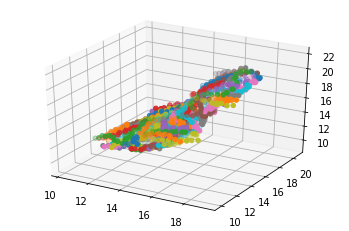

In [6]:
morphoscanner.plot.plot_peptide_from_tensor(coordinate_tens, [e for e in range(coordinate_tens.shape[0])])

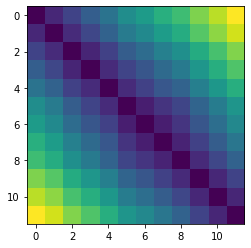

In [11]:
plt.imshow(distance_tens[0][0])

In [15]:
ff = coordinate_tens.cpu().numpy()

In [16]:
ff

array([[[12.571, 17.451, 13.25 ],
        [12.263, 17.281, 13.185],
        [12.107, 17.317, 12.826],
        ...,
        [11.081, 17.204, 11.133],
        [11.106, 17.162, 10.775],
        [10.88 , 17.225, 10.517]],

       [[14.438, 11.267, 14.423],
        [14.566, 11.262, 14.742],
        [14.831, 11.256, 14.924],
        ...,
        [16.455, 10.583, 15.709],
        [16.817, 10.448, 15.67 ],
        [17.106, 10.499, 15.444]],

       [[12.252, 13.295, 12.504],
        [12.371, 13.151, 12.244],
        [12.667, 13.128, 12.069],
        ...,
        [13.781, 12.225, 11.713],
        [13.627, 11.985, 11.895],
        [13.505, 11.716, 12.062]],

       ...,

       [[16.796, 16.304, 18.501],
        [17.14 , 16.255, 18.686],
        [17.181, 15.945, 18.891],
        ...,
        [18.521, 14.41 , 19.768],
        [18.641, 14.185, 20.006],
        [18.909, 14.038, 20.193]],

       [[12.589, 16.017, 11.651],
        [12.63 , 15.759, 11.395],
        [12.357, 15.566, 11.428],
        .